In [1]:
import argparse
import pickle
from collections import namedtuple
from itertools import count
from random import randrange, uniform
import os, time, json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import gym
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
!pip install tensorboardX

In [3]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from tensorboardX import SummaryWriter

In [4]:
class Net(nn.Module):
    def __init__(self, num_state, num_action):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_state, 100)
        self.activation = nn.LeakyReLU() 
        self.fc2 = nn.Linear(100, num_action)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        action_prob = self.fc2(x)
        return action_prob


In [5]:
class DQN():
    def __init__(self, num_state, num_action, params):
        super(DQN, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("using %s" % self.device)

        # data collection aids
        self.name = 'agents/' + params.env_name + '_' + params.model_name
        self.losses = []
        self.my_loss = 0
        self.params = params 
        if self.params.mode == 'test':
            self.load(self.name)
        else:
            self.target_net, self.act_net = Net(num_state, num_action), Net(num_state, num_action)
            self.target_net, self.act_net = self.target_net.to(self.device), self.act_net.to(self.device)
            self.unpack_params()
            self.loss_func = nn.MSELoss()
            self.writer = SummaryWriter('./DQN/logs')
            self.num_actions = num_action 
            self.num_states = num_state
            self.memory_count = 0 
            self.update_count = 0

    def unpack_params(self):
        self.epsilon = self.params.exploration_noise
        self.optimizer = get_optimizer(self.params.optimizer, self.act_net, self.params.learning_rate)
        self.capacity = self.params.capacity
        self.memory = [None]*self.capacity
        self.update_point = self.params.update_count 
        self.gamma = self.params.gamma
        self.batch_size = self.params.batch_size
        self.game = self.params.env_name

    def select_action(self,state):
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        state = state.to(self.device)
        value = self.act_net(state)
        action_max_value, index = torch.max(value, 1)
        action = index.item()
        if np.random.uniform() >= 1 - self.epsilon: 
            action = np.random.choice(range(self.num_actions), 1).item()
        return action

    def store_transition(self,transition):
        index = self.memory_count % self.capacity
        self.memory[index] = transition
        self.memory_count += 1
    
    def update_target_network_weights(self):
        if self.update_count == self.update_point:
            self.update_count = 0 
            self.target_net.load_state_dict(self.act_net.state_dict())

    def update(self):
        if self.memory_count >= self.capacity:

            # convert inputs to torch tensors. 
            state = torch.Tensor([t.old_state for t in self.memory]).float()
            action = torch.LongTensor([t.action for t in self.memory]).view(-1,1).long()
            reward = torch.Tensor([t.reward for t in self.memory]).float()
            next_state = torch.Tensor([t.new_state for t in self.memory]).float()
        
            # move to device
            state = state.to(self.device)
            action = action.to(self.device)
            reward = reward.to(self.device)
            next_state = next_state.to(self.device)

            # normalize rewards. 
            reward = (reward - reward.mean()) / (reward.std() + 1e-7)

            # update Q value
            with torch.no_grad():
                target_v = reward + self.gamma * self.target_net(next_state).max(1)[0]
            
            batch_loss = 0
            # sample from replay buffer, update actor network. 
            for index in BatchSampler(SubsetRandomSampler(range(len(self.memory))), batch_size=self.batch_size, drop_last=False):
                v = (self.act_net(state).gather(1, action))[index]
                loss = self.loss_func(target_v[index].unsqueeze(1), (self.act_net(state).gather(1, action))[index])
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.writer.add_scalar('loss/value_loss', loss, self.update_count)
                batch_loss += loss.item()
                self.my_loss = batch_loss/self.batch_size

            self.losses.append(batch_loss/self.batch_size)
            
        # update target Q network when sufficient iterations have passed. 
        self.update_count +=1
        self.update_target_network_weights() 
        if self.update_count == self.update_point:
            self.target_net.load_state_dict(self.act_net.state_dict())
    
    def save(self, ep_number):
        if not os.path.isdir('agents'):
            os.mkdir('agents/')
        act_model_path = 'agents/' + self.params.model_name + '_' + self.game + '_actor_episode' + str(ep_number) + '.pth'
        target_model_path = 'agents/' + self.params.model_name + '_' + self.game + '_target_episode' + str(ep_number)+ '.pth'
        torch.save(self.act_net.state_dict(), act_model_path)
        torch.save(self.target_net.state_dict(), target_model_path)

        save_dic = vars(self.params)

        save_dic['num_actions'] = self.num_actions 
        save_dic['num_states'] = self.num_states 
        save_dic['memory_count'] = self.memory_count 
        save_dic['update_count'] = self.update_count
        save_dic['losses'] = self.losses

        filename = self.name + '.json'
        with open(filename, 'w') as fp:
            json.dump(save_dic, fp, indent=4)

    def load(self, name):
        # name = 'agents/' + game + '_' + model_name
        filename = name + '.json'
        print('loading from : ', filename) 
        try:
            with open(filename, 'r') as fp:
                data = json.load(fp)
        except FileNotFoundError:
            raise FileNotFoundError("Specified agent does not exist. Aborting.")
        
        self.params = argparse.Namespace(**data)
        self.num_actions = data['num_actions']
        self.num_states = data['num_states']
        ep_number = self.params.num_episodes - 1
        act_model_path = 'agents/' + self.params.model_name + '_' + self.params.env_name + '_actor_episode' + str(ep_number) + '.pth'
        target_model_path = 'agents/' + self.params.model_name + '_' + self.params.env_name + '_target_episode' + str(ep_number)+ '.pth'

        # load the models.
        self.act_net, self.target_net = Net(self.num_states, self.num_actions), Net(self.num_states, self.num_actions)
        self.act_net, self.target_net = self.act_net.to(self.device), self.target_net.to(self.device)
        self.act_net.load_state_dict(torch.load(act_model_path))
        self.target_net.load_state_dict(torch.load(target_model_path))
        
        # load other parameters.
        self.unpack_params() 
        self.memory_count = data['memory_count']
        self.update_count = data['update_count']
        self.losses = data['losses']


In [6]:
class Transition(object):
    def __init__(self, old_state, action, new_state, reward: float, terminate_: bool):
        self.old_state = old_state
        self.action = action
        self.new_state = new_state
        self.reward = reward
        self.terminate = terminate_

    @property
    def terminate(self):
        return self.__terminate

    @terminate.setter
    def terminate(self, terminate_):
        if isinstance(terminate_, bool):
            self.__terminate = terminate_
        else:
            raise TypeError(f'{terminate_} should be bool type')

    def get_transition_tuple(self) -> tuple:
        return self.old_state, self.action, self.new_state, self.reward, self.terminate


In [7]:
def initialize_game(params):
    env = gym.make(params.env_name).unwrapped
    num_state = env.observation_space.shape[0]
    num_action = env.action_space.n
    dqn = DQN(num_state, num_action, params)
    return env, num_state, num_action, dqn 

def get_optimizer(name, net, learning_rate):
    if name.lower() == 'adam':
        optimizer = optim.Adam(net.parameters(), learning_rate)
    elif name.lower() == 'adagrad':
        optimizer = optim.Adagrad(net.parameters(), learning_rate)
    elif name.lower() == 'adadelta':
        optimizer = optim.Adadelta(net.parameters(), learning_rate)
    elif name.lower() == 'sgd':
        optimizer = optim.SGD(net.parameters(), learning_rate)
    elif name.lower() == 'rmsprop':
        optimizer = optim.RMSprop(net.parameters(), learning_rate)
    return optimizer 


In [8]:
def display_state_action_dims(games):
    for env_name in games:
        env = gym.make(env_name).unwrapped
        num_state = env.observation_space.shape[0]
        num_action = env.action_space.n
        print("%s | num_states : %s | num_actions: %s" % (env_name, num_state, num_action))


In [9]:
def main(params):
    global iters 
    iters = []
    global ep_loss
    ep_loss = []
    env, num_state, num_action, agent = initialize_game(params)
    for i_ep in range(params.num_episodes):
        state = env.reset()
        if params.render: env.render()
        if i_ep % (params.log_interval-1) == 0 and i_ep > 0:
            agent.save(i_ep)
        tot_loss = 0
        for t in range(params.num_iterations):
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            if params.render: env.render()
            transition = Transition(state, action, next_state, reward, done)
            agent.store_transition(transition)
            agent.update()
            agent.losses
            
            tot_loss += agent.my_loss
        iters.append(i_ep)
        ep_loss.append(tot_loss)
             
        if i_ep % 10 == 9:
            print("episode {},  iteration {} ".format(i_ep, t))
    
    return agent 


In [10]:
!pip install Box2D 
!pip install box2d-py

# Default Hyperparameters 


MountainCar-v0 | num_states : 2 | num_actions: 3
CartPole-v0 | num_states : 4 | num_actions: 2
LunarLander-v2 | num_states : 8 | num_actions: 4
Acrobot-v1 | num_states : 6 | num_actions: 3
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 


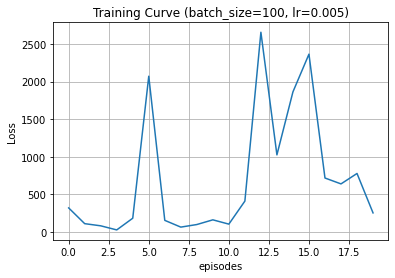

In [11]:
if __name__ == "__main__":

    supported_games = ['MountainCar-v0',
                       'CartPole-v0',
                       'LunarLander-v2',
                       'Acrobot-v1'
                       ]
    
    display_state_action_dims(supported_games)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    parser = argparse.ArgumentParser()
    parser.add_argument('--mode', default='train', type=str) # mode = 'train' or 'test'
    # model parameters. 
    parser.add_argument('--env_name', default='LunarLander-v2',)
    parser.add_argument('--update_count', default=150, type=int) # number of iterations before transferring weights. 
    parser.add_argument('--learning_rate', default=1e-5, type=float) # learning rate for networks. 
    parser.add_argument('--gamma', default=0.95, type=int) # discounted factor
    parser.add_argument('--capacity', default=10, type=int) # replay buffer size
    parser.add_argument('--num_iterations', default=1000, type=int) #  num of iterations per episode
    parser.add_argument('--batch_size', default=100, type=int) # mini batch size
    parser.add_argument('--seed', default=True, type=bool) 
    parser.add_argument('--random_seed', default=9527, type=int)
    parser.add_argument('--sample_type', default='uniform', type=str) # uniform or prioritized - can consider if we have the time. 
    parser.add_argument('--exploration_noise', default=0.1, type=float) # epsilon for epsilon-greedy policy. 
    parser.add_argument('--num_episodes', default=20, type=int) # number of episodes.
    parser.add_argument('--optimizer', default='adam', type=str) # optimizer to be used. 
    parser.add_argument('--model_name', default='default_dqn', type=str)

    # optional parameters
    parser.add_argument('--num_hidden_layers', default=4, type=int)
    parser.add_argument('--sample_frequency', default=256, type=int)
    parser.add_argument('--render', default=False, type=bool) # show UI or not
    parser.add_argument('--log_interval', default=50, type=int) #
    parser.add_argument('--load', default=False, type=bool) # load model
    parser.add_argument('--render_interval', default=100, type=int) # after render_interval, the env.render() will work
    parser.add_argument('--policy_noise', default=0.2, type=float)
    parser.add_argument('--noise_clip', default=0.5, type=float)
    parser.add_argument('--policy_delay', default=2, type=int)
    
    args, _ = parser.parse_known_args()

    # pass args into the main function 
    agent = main(args)
   

    
# plotting
plt.plot(iters, ep_loss)
plt.title("Training Curve (batch_size=100, lr=0.005)")
plt.xlabel("episodes")
plt.ylabel("Loss")
plt.grid()

In [12]:
def hyper_param(lr, nbatch_size, optimizer, discount_factor, game_type):
    parser = argparse.ArgumentParser()
    parser.add_argument('--mode', default='train', type=str) # mode = 'train' or 'test'
    # model parameters. 
    parser.add_argument('--env_name', default=game_type,)
    parser.add_argument('--update_count', default=150, type=int) # number of iterations before transferring weights. 
    parser.add_argument('--learning_rate', default=lr, type=float) # learning rate for networks. 
    parser.add_argument('--gamma', default=discount_factor, type=int) # discounted factor
    parser.add_argument('--capacity', default=10, type=int) # replay buffer size
    parser.add_argument('--num_iterations', default=1000, type=int) #  num of iterations per episode
    parser.add_argument('--batch_size', default=nbatch_size, type=int) # mini batch size
    parser.add_argument('--seed', default=True, type=bool) 
    parser.add_argument('--random_seed', default=9527, type=int)
    parser.add_argument('--sample_type', default='uniform', type=str) # uniform or prioritized - can consider if we have the time. 
    parser.add_argument('--exploration_noise', default=0.1, type=float) # epsilon for epsilon-greedy policy. 
    parser.add_argument('--num_episodes', default=20, type=int) # number of episodes.
    parser.add_argument('--optimizer', default=optimizer, type=str) # optimizer to be used. 
    parser.add_argument('--model_name', default='default_dqn', type=str)

    # optional parameters
    parser.add_argument('--num_hidden_layers', default=4, type=int)
    parser.add_argument('--sample_frequency', default=256, type=int)
    parser.add_argument('--render', default=False, type=bool) # show UI or not
    parser.add_argument('--log_interval', default=50, type=int) #
    parser.add_argument('--load', default=False, type=bool) # load model
    parser.add_argument('--render_interval', default=100, type=int) # after render_interval, the env.render() will work
    parser.add_argument('--policy_noise', default=0.2, type=float)
    parser.add_argument('--noise_clip', default=0.5, type=float)
    parser.add_argument('--policy_delay', default=2, type=int)
    
    args, _ = parser.parse_known_args()
    return args

# Random Search
1. MountainCar-v0

using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 


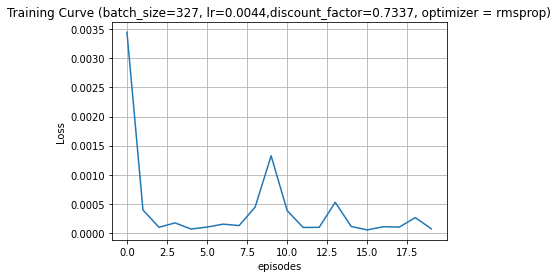

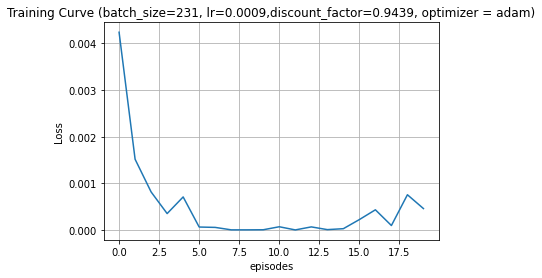

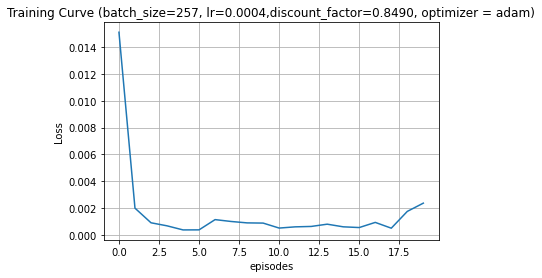

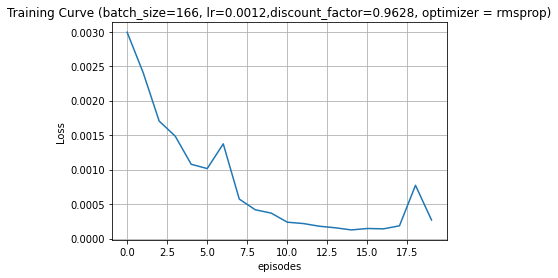

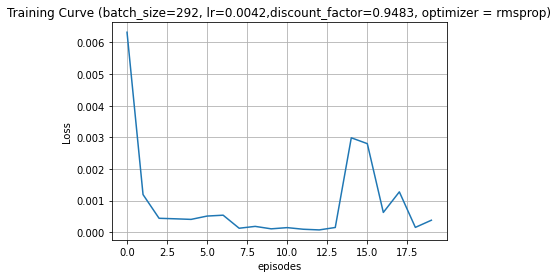

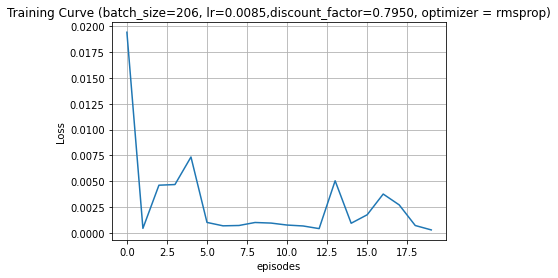

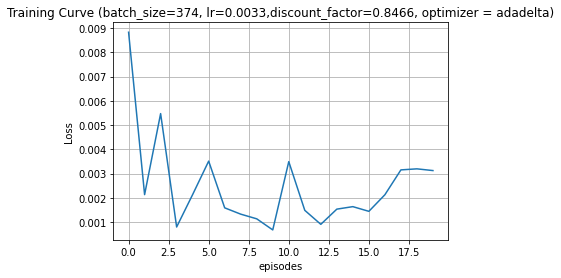

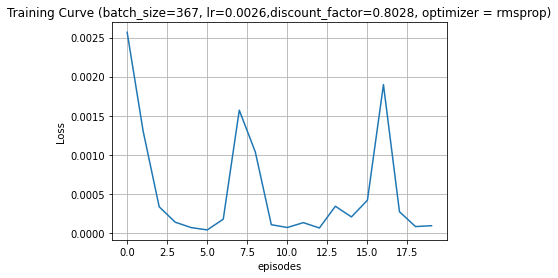

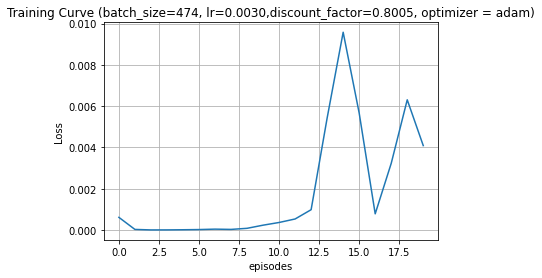

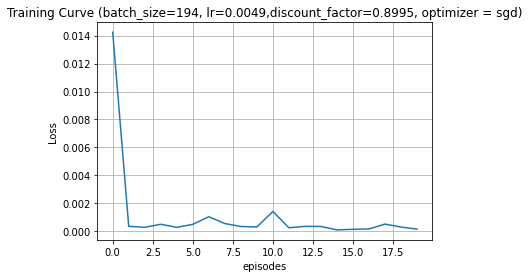

In [14]:
import random

def hyper_param_ch_game(game_type):
  lrs = [uniform(3e-4,1e-2) for p in range(0, 10)]
  discount_factors = [uniform(.99,.7) for p in range(0, 10)]
  nbatch_sizes = [randrange(64,512) for p in range(0, 10)]
  optimizers = ['adam', 'adagrad', 'adadelta', 'sgd', 'rmsprop']

  for lr, nbatch_size, discount_factor in zip(lrs, nbatch_sizes, discount_factors):
    optimizer = random.choice(optimizers)
    args = hyper_param(lr, nbatch_size, optimizer, discount_factor, game_type)
    # pass args into the main function 
    agent = main(args)
    plt.figure()
    plt.plot(iters, ep_loss)
    plt.title("Training Curve (batch_size={}, lr={:.4f},discount_factor={:.4f}, optimizer = {})".format(nbatch_size, lr, discount_factor, optimizer))
    plt.xlabel("episodes")
    plt.ylabel("Loss")
    plt.grid()
game_type = 'MountainCar-v0'
hyper_param_ch_game(game_type)

2. CartPole-v0

using cuda


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda


Streaming output truncated to the last 5000 lines.


episode 9,  iteration 999 


Streaming output truncated to the last 5000 lines.


episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda


Streaming output truncated to the last 5000 lines.


episode 9,  iteration 999 


Streaming output truncated to the last 5000 lines.


episode 19,  iteration 999 


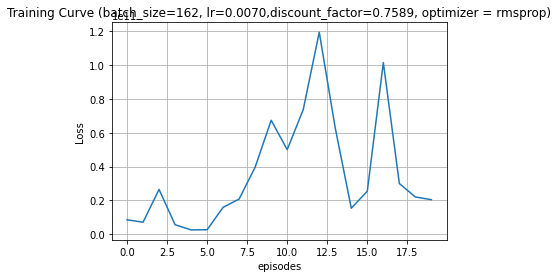

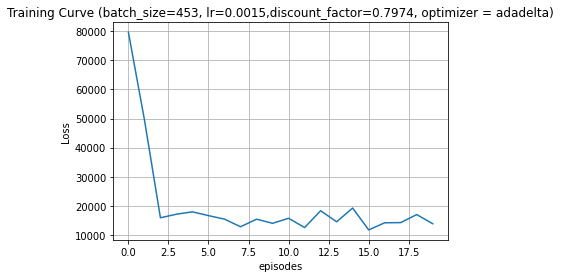

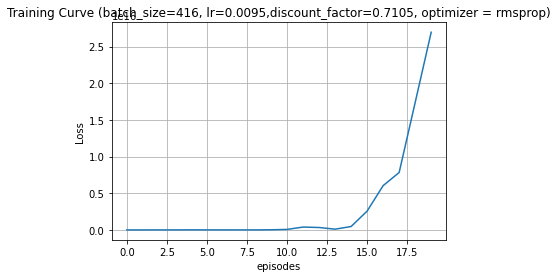

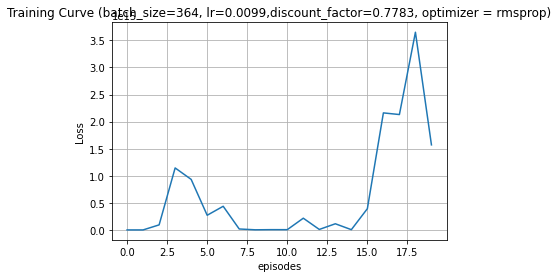

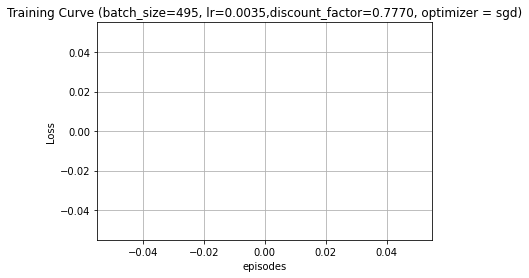

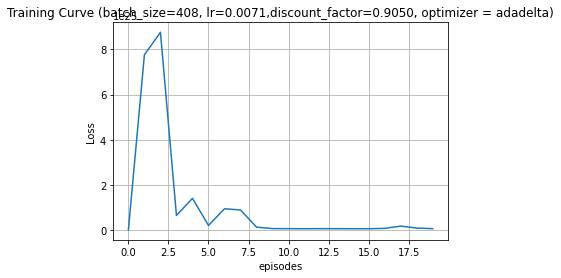

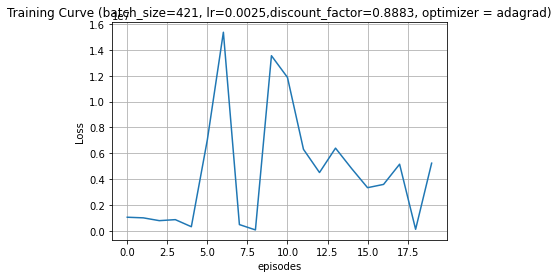

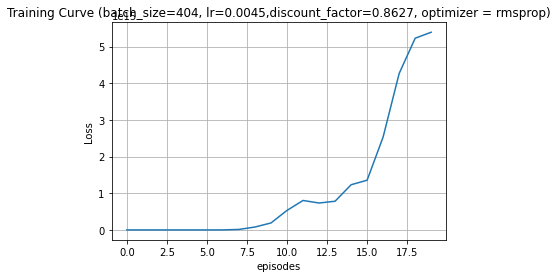

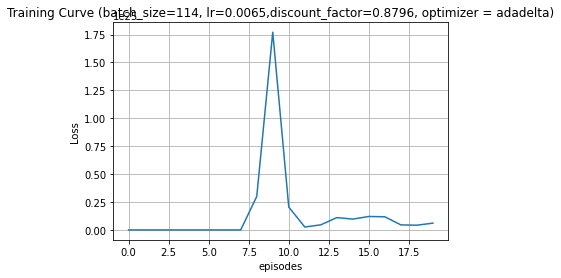

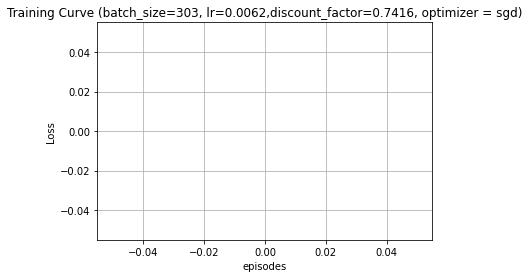

In [15]:
game_type = 'CartPole-v0'
hyper_param_ch_game(game_type)

3. LunarLander-v2

using cuda
episode 9,  iteration 999 


Streaming output truncated to the last 5000 lines.


episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 


Streaming output truncated to the last 5000 lines.


episode 19,  iteration 999 
using cuda


episode 9,  iteration 999 


Streaming output truncated to the last 5000 lines.


episode 19,  iteration 999 


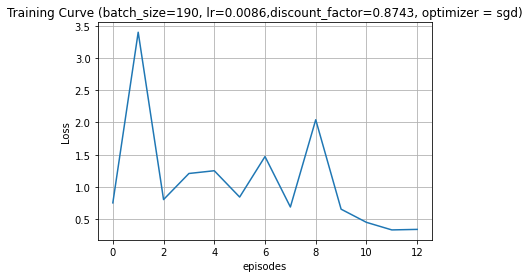

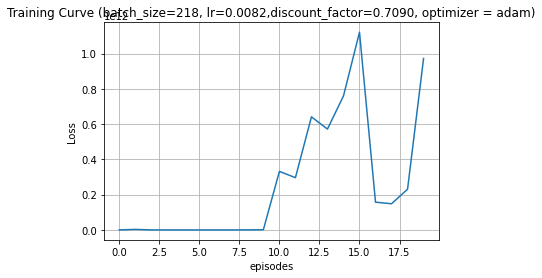

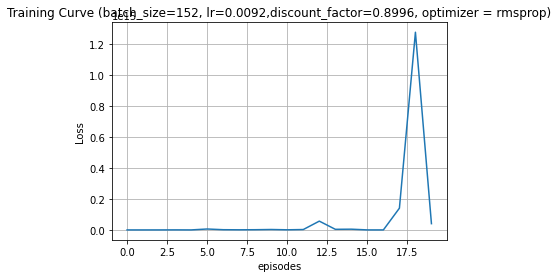

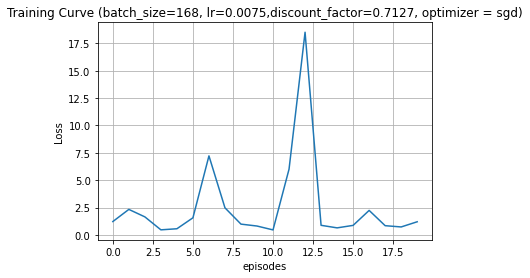

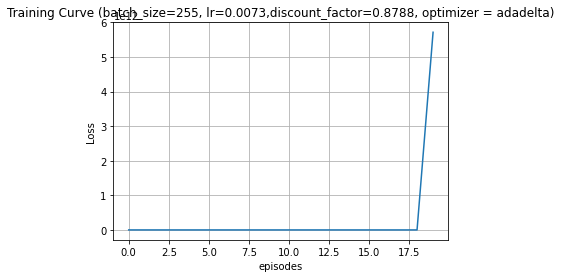

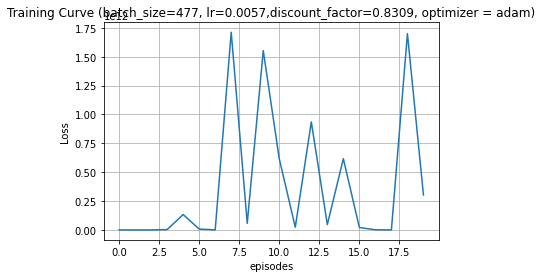

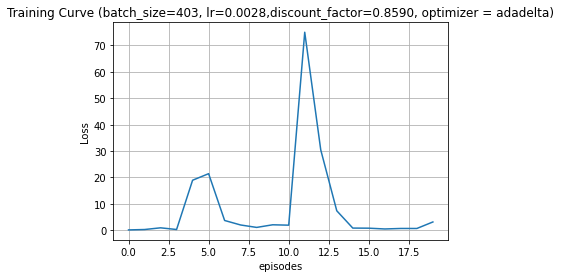

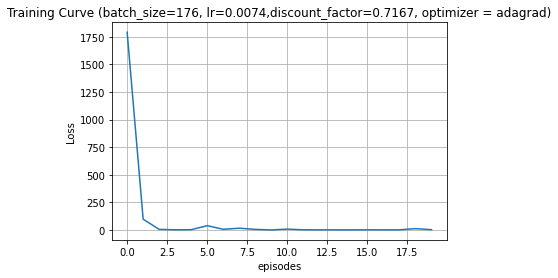

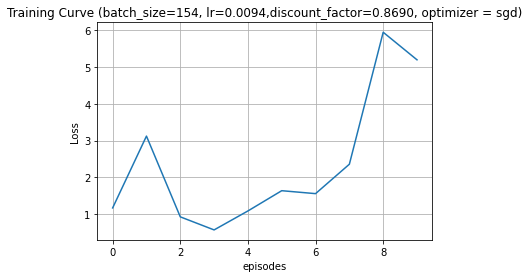

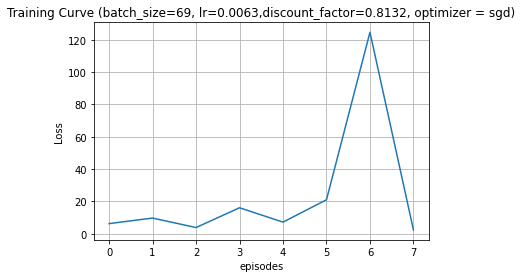

In [16]:
game_type = 'LunarLander-v2'
hyper_param_ch_game(game_type)

4. Acrobot-v1

using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 
using cuda
episode 9,  iteration 999 
episode 19,  iteration 999 


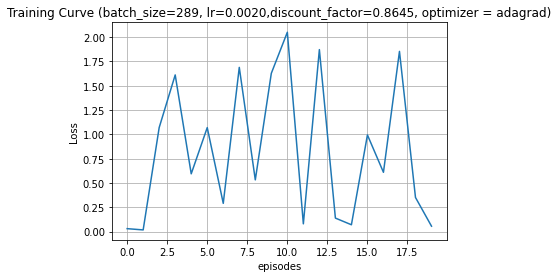

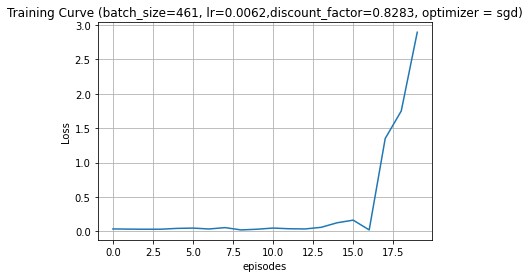

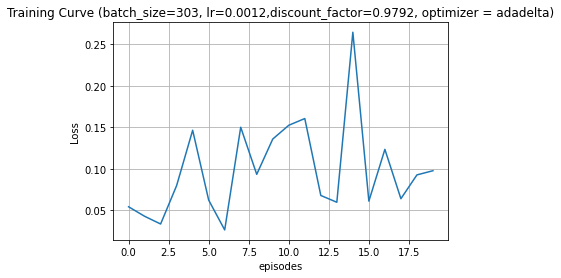

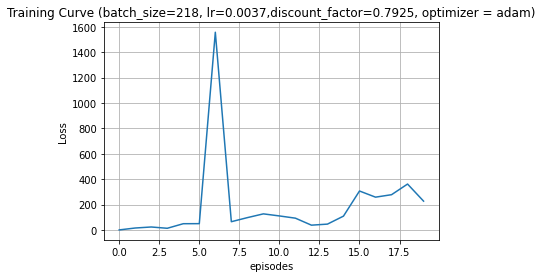

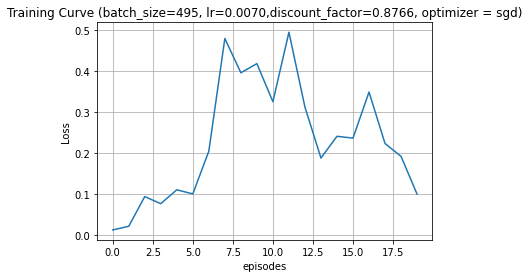

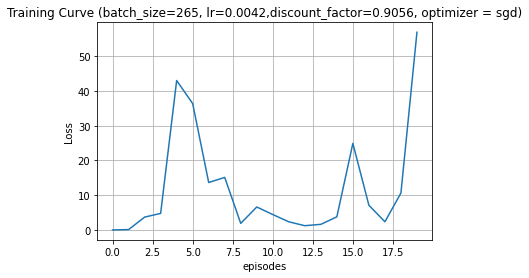

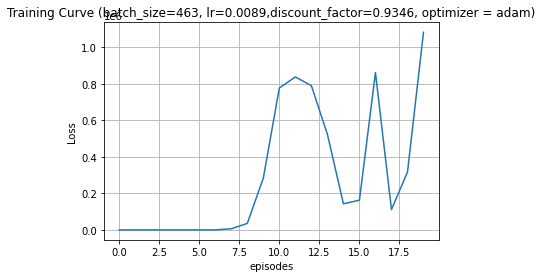

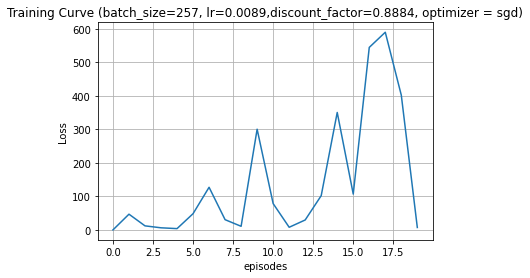

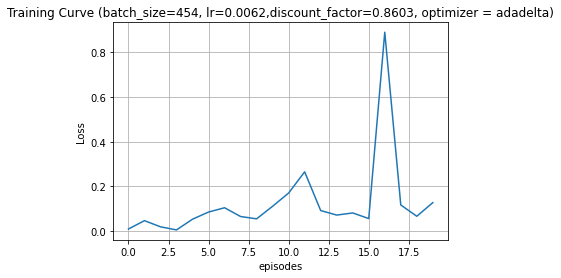

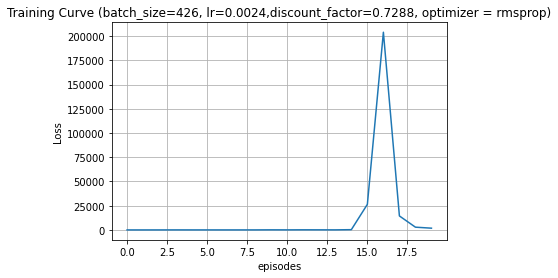

In [17]:
game_type = 'Acrobot-v1'
hyper_param_ch_game(game_type)